# Data Bootcamp Final Project: AirBnB and the Starbucks Effect in NYC
<br>
<br>
<img src="https://upload.wikimedia.org/wikipedia/commons/6/69/Airbnb_Logo_B%C3%A9lo.svg" style="width: 100px;"/>
<img src="https://enterpryze.com/wp-content/uploads/2016/10/Starbucks-Logo-PNG-Transparent-Image-420x164.png" style="width: 150px;"/>

**Written By: Mark Etem**  

**Last Updated: December 14, 2017**  

**Email: [mark.etem@gmail.com](mark.etem@gmail.com)**

We know that property values can be positively [influenced or predicted by the presence of Starbucks](https://qz.com/334269/what-starbucks-has-done-to-american-home-values/), but what about short term accomodation prices? The purpose of this project is to see whether Starbucks is affecting more dynamic, short term rental prices. To do that, we will explore the relationship between Starbucks and AirBnb in the context of New York City.  Specifically, we would like to examine the correlation between Starbucks proximity and AirBnb prices, as well as the effect over time of Starbucks locations on AirBnb availability.  
<br>
Contents: 
<br>
1. Data Report
2. Packages
3. Importing Data
4. Heat Map
5. Proximity and Price
6. Recency and Price
7. Conclusion

## Data Report

Datasets:
1.	Starbucks: [The ‘All Starbucks Locations in the World’ dataset on Socrata](https://opendata.socrata.com/Business/All-Starbucks-Locations-in-the-World/xy4y-c4mk)
2.	AirBnb: [AirBnb ‘Get The Data’ listing data on New York City](http://insideairbnb.com/get-the-data.html)

Both datasets used in this project are accessible to the public.  
<br>
The Starbucks dataset was compiled by Chris Meller on Socrata, though the API that allowed the database to be scraped was discontinued in July, 2017 and the most recent store added is dated December, 2016. It was first scraped in December, 2013 so only stores opened after that date include a usable time element. The dataset also includes contact and location information. Because this dataset is hosted on Socrata, it is possible to query the SODA API for New York specifically. Note that there are some stores that are different brands owned by Starbucks.

AirBnb [released troves of NYC data two years ago](https://www.nytimes.com/2015/12/02/technology/airbnb-releases-trove-of-new-york-city-home-sharing-data.html?_r=0) as part of their Inside AirBnb initiative. They also list information on other localities all around the world. This dataset includes over 60 datapoints including location, availability, pricing, reviews, and more. Unfortunately no one has begun a hosted database of this information over time, so the only data that could be used as a timeseries is availability, which is noted in days out of the last 30, 60, 90, and 365. Unfortunately, at this writing, that does not overlap with timeseries data from Starbucks, and the averaging required to look at these periods dilutes the data significantly. Note that this database is only available for download and is extremely large. 

## Packages

- `Requests` used to query SODA API  
- `Pandas` used to generate dataframes, analyze  
- `Basemap` used to map  
- `Matplotlib` used to plot  
- `Numpy` used for logs  
- `Geopy` used to determine distances  
- `Datetime` used for timeseries  
- `Statsmodels` used for regression line
- `Seaborn` used for easy best fit line

In [1070]:
import requests #importing requests module for api
import pandas as pd #importing pandas module for DataFrames
from mpl_toolkits.basemap import Basemap #importing basemap for maps
import matplotlib.pyplot as plt #importing matplotlib for graphs and plots
import numpy as np #importing numpy for analysis
from geopy.distance import great_circle #importing geopy for distance calculations
from datetime import date #importing datetime for timeseries 
import statsmodels.api as sm #importing statsmodels for regression line
import statsmodels.formula.api as smf #importing statsmodels for regression line
import seaborn as sns #importing seaborn for easy regression lines

%matplotlib inline 
#renders matplotlib plots in Jupyter Notebook

## Importing Data 
**Starbucks from Socrata API**  

In [1071]:
#socrata api url queried for New York
r = requests.get('https://opendata.socrata.com/resource/xy4y-c4mk.json?country_subdivision=NY') 
x = r.json()
stardf = pd.DataFrame(x)
stardf.columns

Index(['brand', 'city', 'coordinates', 'country', 'country_subdivision',
       'current_timezone_offset', 'first_seen', 'latitude', 'longitude',
       'name', 'olson_timezone', 'ownership_type', 'phone_number',
       'postal_code', 'store_id', 'store_number', 'street_1', 'street_2',
       'street_3', 'street_combined', 'timezone'],
      dtype='object')

In [1072]:
stardf.shape

(640, 21)

**Scrubbing Starbucks Data**  
<br>
There are 640 Starbucks locations in New York State. The city location data is thrown off by the use of boroughs, so we have to use state level selection querying the API. One observation for someone interested in following up is that every starbucks has a store number and a store id. We'll use store id for the purpose of this project.  
<br>
To clean this data we'll need to do two things: 
1. Reduce the number columns: we really only need an identifier, location, and creation timestamp
2. Change the types for calculations: coordinates to floats and timeseries information to datetime

In [1073]:
#choosing useful columns 
stardf = stardf[['store_id',                  #identifier
                 'longitude','latitude',      #location data
                 'first_seen',                #timeseries data
                 'country_subdivision']].copy() #data for easy merge

#changing type of timeseries data
stardf['first_seen'] = pd.to_datetime(stardf['first_seen']) #pandas making timeseries data into datetime format
stardf['first_seen'] = [time.date() for time in stardf['first_seen']] #really only need date, not hours and mins 

#changing type of location data
stardf.longitude = stardf.longitude.astype(float).copy()  #to float 
stardf.latitude = stardf.latitude.astype(float).copy()  #to float

stardf.head()

,store_id,longitude,latitude,first_seen,country_subdivision
0,6348,-73.831879,40.714371,2013-12-08,NY
1,6491,-73.288651,40.806366,2013-12-08,NY
2,6535,-76.236130,43.046398,2013-12-08,NY
3,6551,-73.947243,40.631264,2013-12-08,NY
4,6590,-73.975327,40.789288,2013-12-08,NY


**AirBnb from downloaded CSV**

In [1074]:
#local csv file
airlist = '/Users/marketem/Data_Bootcamp/listings.csv'
# create dataframe
airdf = pd.read_csv(airlist)
airdf.columns

/Users/marketem/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (43,88) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

**Scrubbing AirBnb Data** 
<br>
Wow, over 44,000 AirBnb's in New York City. As we can see there is also a huge number of columns, most of which we won't use for this analysis. It is worth it to note that there is potential in exploring the comprehensive review data here, although it wasn't used in this project.
<br>
To clean this up:  
1. For size: Get rid of the columns we don't need 
2. For calculations: Remove unnecessary figures '$' and ',' from pricing

Again the city data is complicated by boroughs, so the state will be used for merging purposes later (the dataset is specifically New York City, though). 

Previously, I tried cleaning up the dataset by removing inactive AirBnbs, but AirBnb has done a good job of purging accomodations that aren't current. We'll leave the full set here for the first map, but afterwards this project will use a representative sample. 

In [1075]:
#Selecting useful columns
airdf = airdf[['id',          #identifier
               'price',       #price
               'latitude', 'longitude', #location
               'state']].copy() #state for merge

#Cleaning price column
airdf.price = airdf.price.str.replace("$","") #removing '$'
airdf.price = airdf.price.str.replace(",","") #removing ','
airdf.price = airdf.price.astype(float) #change type to float
airdf.head()

,id,price,latitude,longitude,state
0,18461891,110.0,40.774142,-73.916246,NY
1,20702398,50.0,40.849191,-73.786509,NY
2,6627449,125.0,40.849775,-73.786609,NY
3,19949243,100.0,40.848838,-73.782276,NY
4,1886820,300.0,40.841144,-73.783052,NY


## Heat Map  
First, let's get a general idea of how Starbucks and AirBnb's map onto eachother geographically in New York City.

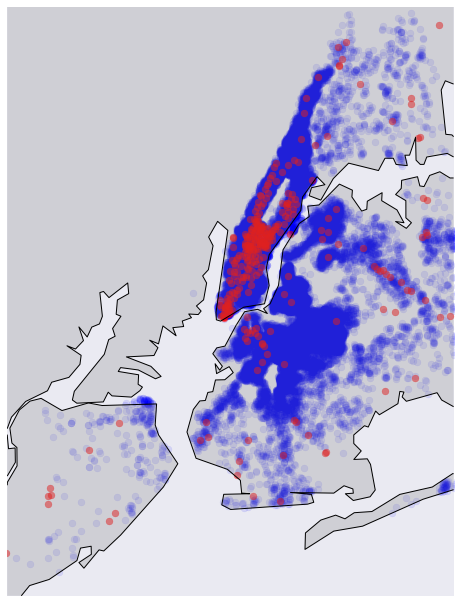

In [1076]:
#Make a map of New York City

plt.figure(figsize=(8,12)) #basic figure which can be read into Basemap

nyc_map = Basemap(projection='merc', # mercantile projection
                 resolution = 'h', # high res for local map
                 llcrnrlon=-74.206, llcrnrlat=40.513, # setting the corner coordinates of the map
                 urcrnrlon=-73.806, urcrnrlat=40.913) # centered on New York City: 40.7128° N, 74.0060° W

nyc_map.drawcoastlines() #adding coastlines to the map

nyc_map.fillcontinents(color='grey', alpha = 0.25, lake_color='aqua') #filling the map with a color

#########################################################################################################

#Add Starbucks and AirBnb locations as points on the map

#plotting airbnb data - placed on bottom to accommodate density

x,y = nyc_map(airdf.longitude.tolist(),airdf.latitude.tolist()) # pulling longitude and latitude for points
nyc_map.scatter(x,y, latlon = False, alpha = 0.1, color = "blue") # using scatter to plot in BLUE

#plotting starbucks data

x,y = nyc_map(stardf.longitude.tolist(),stardf.latitude.tolist()) # pulling longitude and latitude for points
nyc_map.scatter(x,y, latlon = False, alpha = .5, color = "red") # using scatter to plot in RED

plt.show()

This heat map gives us a general overview of the New York City area and the presence of Starbucks (in red) and AirBnb's (in blue). There does seem to be heavy correlation between the two, but that does not appear to be true at the fringes. It is possible that Starbucks may be currently leading future development of AirBnbs, but we also must consider other possibilites as well, such as certain areas being demarcated as industrial or commercial.

## Proximity and Price
To replicate the 'Starbucks Effect' among AirBnb rentals we will look for correlation between the closeness of Starbucks and the price level of AirBnbs. Specifically, we'll look at Starbucks within a radius of 1 mile from each AirBnb (what would reasonably be considered walking distance) and calculate the distance to the closest starbucks within that radius. That proximity will be plotted against price. 

To examine proximity and price, we will:  

- Take a sample of the AirBnb data
- Merge Starbucks data and AirBnb sample 
- Compute the distance between each AirBnb from our sample and all Starbucks (long computation)
- Make some calculations based on that distance  
- Merge them back into final usable dataframe  
- Plot distance calculations against price  

In [1077]:
#Here we're taking 5% of the overall AirBnb dataset

airdf_sample = airdf.sample(n=2215) #sample method to select randomly
airdf_sample.shape

(2215, 5)

In [1078]:
#merge every airbnb with all starbucks locations
air_star = pd.merge(airdf_sample, stardf, left_on='state', right_on= 'country_subdivision')
air_star.head()

,id,price,latitude_x,longitude_x,state,store_id,longitude_y,latitude_y,first_seen,country_subdivision
0,20439257,145.0,40.7003,-73.940138,NY,6348,-73.831879,40.714371,2013-12-08,NY
1,20439257,145.0,40.7003,-73.940138,NY,6491,-73.288651,40.806366,2013-12-08,NY
2,20439257,145.0,40.7003,-73.940138,NY,6535,-76.236130,43.046398,2013-12-08,NY
3,20439257,145.0,40.7003,-73.940138,NY,6551,-73.947243,40.631264,2013-12-08,NY
4,20439257,145.0,40.7003,-73.940138,NY,6590,-73.975327,40.789288,2013-12-08,NY


**Distance calculation**

In [1079]:
t = datetime.datetime.now()

In [1080]:
#determine distance between each AirBnb and all Starbucks with geopy great circle function

air_star['distance'] = air_star.apply(                # distance information in new column 'distance'
    lambda x: great_circle((x['latitude_x'], x['longitude_x']), # function set geopy great circle
                           (x['latitude_y'], x['longitude_y'])).miles, axis = 1) #uses lon/lat info to calculate
                                                                                 #returns miles
air_star.head()

,id,price,latitude_x,longitude_x,state,store_id,longitude_y,latitude_y,first_seen,country_subdivision,distance
0,20439257,145.0,40.7003,-73.940138,NY,6348,-73.831879,40.714371,2013-12-08,NY,5.754554
1,20439257,145.0,40.7003,-73.940138,NY,6491,-73.288651,40.806366,2013-12-08,NY,34.887219
2,20439257,145.0,40.7003,-73.940138,NY,6535,-76.236130,43.046398,2013-12-08,NY,200.611705
3,20439257,145.0,40.7003,-73.940138,NY,6551,-73.947243,40.631264,2013-12-08,NY,4.785817
4,20439257,145.0,40.7003,-73.940138,NY,6590,-73.975327,40.789288,2013-12-08,NY,6.420246


In [1081]:
t1 = datetime.datetime.now()
print('That took:',t1 - t)

That took: 0:02:02.545410


Done! Hopefully that didn't take more than 5 minutes.

Worth it to note here that before limiting max distance some distances are very long (because they are from NYC AirBnb's to Starbucks locations all over the state). By reducing the maximum distance to walking distance (1 mile) we eliminate this problem. 

In [1082]:
#1 mile buffer to remove state-wide distances and to make walking calculations later

air_star = air_star[air_star['distance'] < 1].copy() #boolean operation returning only rows distance 
                                                                    #of 1 mile or less
    
#######################################################################################################

#Basic distance computations

#Closest starbucks (amin), furthest starbucks(amax) and mean distance to all starbucks(mean) within 1 mile

air_star_calcs = air_star.groupby('id')['distance'].agg([pd.np.min, pd.np.max, pd.np.mean]) #groupby airbnb id
                                                            #agg function for numpy distance calculations

air_star_calcs.reset_index(inplace=True) #resetting index to avoid 'id' column issues later

air_star_calcs.head()

,id,amin,amax,mean
0,2595,0.078272,0.993374,0.548531
1,3647,0.187328,0.993532,0.635104
2,7241,0.068063,0.987421,0.686800
3,7816,0.234224,0.986925,0.699353
4,8025,0.217324,0.995442,0.664362


In [1083]:
#merging calculations into dataframe for plotting
a = air_star[['id','price']] #pulling price
b = air_star_calcs[['id','amin']] #pulling closest distance to starbucks (amin)

price_and_proximity = pd.merge(a, b, how='inner', right_on='id', left_on='id') #merged by 'id' 

price_and_proximity.head()

,id,price,amin
0,13731019,92.0,0.11489
1,13731019,92.0,0.11489
2,13731019,92.0,0.11489
3,13731019,92.0,0.11489
4,13731019,92.0,0.11489


**Plotting proximity and price**  
Using the closest distance to a Starbucks we'll see if any correlations exist with price. 

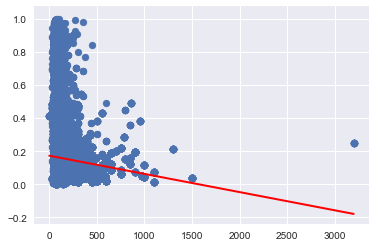

In [1084]:
#Regression model for trend line

results = smf.ols("amin ~ price",     #trend relationship
                  data=price_and_proximity).fit() #datafame to pull from

pred = results.predict(exog = price_and_proximity["price"].sort_values()) #setting x-variable for stats model predict

fig, ax = plt.subplots()

ax.scatter(price_and_proximity['price'], price_and_proximity['amin']) #scatter with price and distance
ax.plot(price_and_proximity["price"].sort_values(), pred , color = 'r', linewidth = 2.0)  #plotting trend line

We can get a sense for the correlation, but we'll use quantiles, below,  show the relationship more clearly.  

An average person walks at 4mph, completing one mile in 15 minutes. The following quantiles are broken into estimated walking times, which is especially illustrative in New York City where walking is very prevelant. 

In [1085]:
#looking at price quantiles and distance averages

quantiles = 3 #number quantiles
labels = ["<5","5-10",">10"] #labels

q = pd.qcut(price_and_proximity["amin"], # quantiles by minimum distance
                quantiles,           # number quantiles
                labels = labels)      # labels

g = price_and_proximity.groupby(q)   # groupby quantiles

price_amin_quantiles = g['price'].mean() # apply to mean price for each quantile

price_amin_quantiles.to_frame()

,price
amin,
<5,243.432163
5-10,206.829652
>10,192.483294


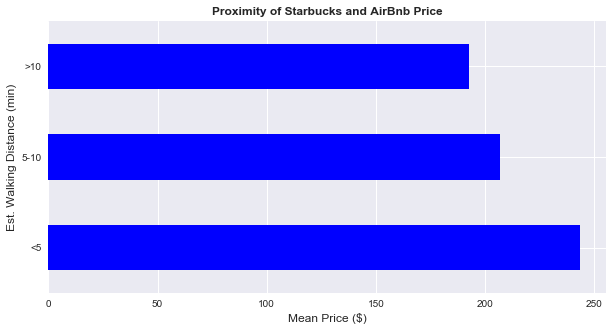

In [1108]:
#now let's put that in a graph

fig, ax = plt.subplots(figsize=(10,5))

price_amin_quantiles.plot(kind='barh', ax=ax, color = 'b') #plotting bar graph

plt.xlabel('Mean Price ($)', fontsize='large')  #label x axis for price
plt.ylabel('Est. Walking Distance (min)',fontsize='large')   #label y axis for walking time
plt.title('Proximity of Starbucks and AirBnb Price', fontsize='large', fontweight='bold') #add title

plt.show()

Breaking this down into quantiles shows us a clear correlation between the distance to the nearest starbucks and the price of that AirBnb. Previously, I did map this into more quantiles and found that the result was linear. 

## Recency and Price
Now that we have seen there is a definite positive correlation between proximity and price, let's try to identify that on a timeline. Specifically, we'd like to see if the presence of a Starbucks predicts increasing prices. This roughly translates to a hypothesis: the longer an AirBnb has had a Starbucks very close, the higher their price will be. Since we have seen that a Starbucks within .33 miles of an AirBnb is correlated to increased price, we will limit the maximum distance to this level.  

To test this, we will:  

- Isolate Starbucks with timeseries information and maximum distance
- Determine how long (recency) each Airbnb has had a new starbucks nearby
- Merge recency data with pricing data
- Plot AirBnb prices by the length of time they have had a starbucks nearby  






In [1087]:
#Here we're only looking at Starbucks that were not in the original scrape from December, 2013

new_stars = stardf.loc[stardf['first_seen'] != date(2013,12,8)].copy() #using precise original scrape time
new_stars.shape

(131, 5)

Ok, now we have only 131 Starbucks from our earlier 640, all added to the Starbucks website after December 2013. It is necessary to note that because we excluded the Starbucks without useful timeseries data, there may have been additional Starbucks within this range that will not be counted in the following graphs. 

Now we'll determine how many days the starbucks have been around, and then use the store id to link that to distance information. 

In [1088]:
#creating recency data by subtracting the first seen date from December 1, 2017

new_stars['recency'] = datetime.date(2017,12,1) - new_stars['first_seen']  #new recency column

new_stars = new_stars[['store_id','recency']].copy()  #just the columns we need

In [1089]:
#merging recency and pricing information

#bringing in distance data from earlier allows us to limit maximums
stars_recency = pd.merge(air_star_dist[['id','price','distance','store_id']], new_stars, #pricing, recency, DISTANCE
                         left_on='store_id', right_on= 'store_id') #matched by store id

stars_recency = stars_recency[stars_recency['distance'] < 0.3].copy() #limiting distance maximums

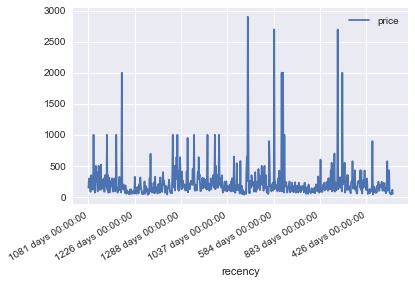

In [1101]:
#create dataframe with only necessary columns for plotting
stars_recency_plot = stars_recency[['price','recency']]

#quick plot of recency and price
stars_recency_plot.plot('recency')

Ok, this shows us roughly how prices look across the days since the closest starbucks was established, but let's look at a scatterplot to establish a trend.

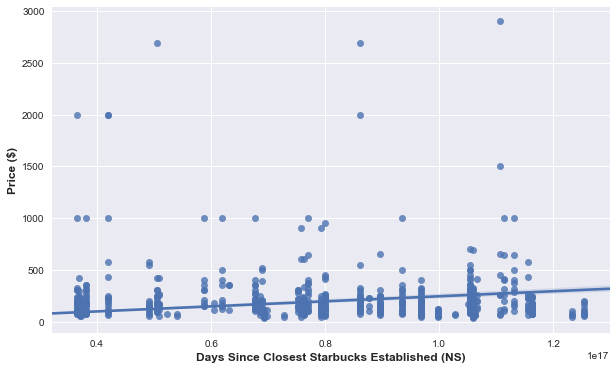

In [1107]:
#data to plot
x = np.array(stars_recency_plot.recency.astype(int)) #setting axis data as arrays
y = np.array(stars_recency_plot['price']) #setting axis data as arrays

ax, fig = plt.subplots(figsize=(10,6))

ax = sns.regplot(x,y,data=stars_recency_plot) #log of y for visual spread, and linear regression line

ax.set_xlabel('Days Since Closest Starbucks Established (NS)', fontsize='large', fontweight='bold') #x-axis label
ax.set_ylabel('Price ($)', fontsize='large', fontweight='bold') #y-axis label

With a linear regression model on the scatterplot we can clearly see a correlation between length of time a starbucks has been within a 5 minute walk, and the price of the AirBnb. However, using both graphs above, we can also see that the real difference in price (in dollars) is relatively small. 

## Conclusion

**In conclusion, there is a positive correlation between both:**  

- the proximity of Starbucks and AirBnb prices
- the amount of time a Starbucks has been close and AirBnb prices

We saw first that there does appear to be a correlation, generally, in geographic terms through the use of a heat map. We also noted that there are some exceptions at the edges of areas with AirBnb's that could be further explored. Next, we looked at the distance to the closest starbucks within walking distance (1 mile, or 15 minutes), and how that compared to prices. Using quantiles broken into three groups, it was very apparent that there is a correlation between proximity and Price. Finally, we explored the amount of time that a Starbucks has existed nearby (very close, 0.33 miles or 5 minutes walking) and the relationship of that to pricing. Again, we saw a possitive correlation here. 

However, there are many factors that might have affected the outcome of these correlations, and the real difference in price is actually very small. Further research could be conducted through the collection of AirBnb data, specifically prices over time, in tandem with freshly collected Starbucks data. Using a timeseries could show more conclusive evidence for Starbucks predicting an increase in prices, as opposed to happening simultaneously. 

Final Tip: if you're thinking of buying an apartment to rent out on AirBnb, maybe look at the closest Starbucks, and how long it's been there!